# Exploring the gliders ERDDAP server

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
)

In [2]:
min_lat, max_lat = 20, 30
min_lon, max_lon = -82, -97
        
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2018-09-01T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [3]:
import pandas as pd


search_url = e.get_search_url(response='csv', **kw)

search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 19 Glider Datasets:
allgcoos_dmacGliders
allrutgersGliders
allsecooraGliders
ng290-20180701T0000
ng295-20180701T0000
ng296-20180701T0000
ng309-20180701T0000
ng342-20180701T0000
ng429-20180701T0000
ng448-20180701T0000
ng450-20180701T0000
ng464-20180701T0000
ng466-20180701T0000
ng489-20180701T0000
ng512-20180701T0000
ng596-20180701T0000
Reveille-20180627T1500
sam-20180824T0000
Sverdrup-20180509T1742


In [4]:
dataset_id = 'sam-20180824T0000'


variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [5]:
e.dataset_id = dataset_id
e.variables = variables

print(
    e.get_download_url(
        response='mat',  # like matlab? ERDDAP has your back!
    )
)

https://data.ioos.us/gliders/erddap/tabledap/sam-20180824T0000.mat?depth,latitude,longitude,salinity,temperature,time


Clicking in the URL above will get a `.mat` file ready for download.
However, we'll stay in the Python world and use pandas to load a `csv`.

In [6]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2018-08-24 22:28:56,2.771356,28.351149,-83.498135,34.554237,29.9049
2018-08-24 22:28:56,3.426940,28.351149,-83.498135,34.592440,29.8862
2018-08-24 22:28:56,4.469911,28.351149,-83.498135,34.635780,29.8539
2018-08-24 22:28:56,5.522809,28.351149,-83.498135,34.670925,29.8730
2018-08-24 22:28:56,6.357177,28.351149,-83.498135,34.725838,29.9482


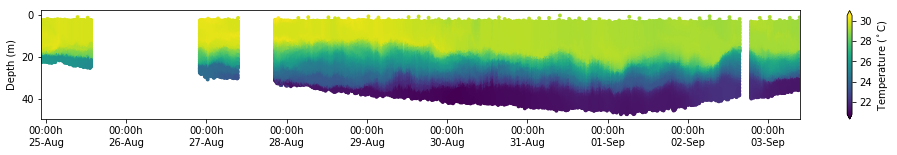

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['temperature'],
                marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

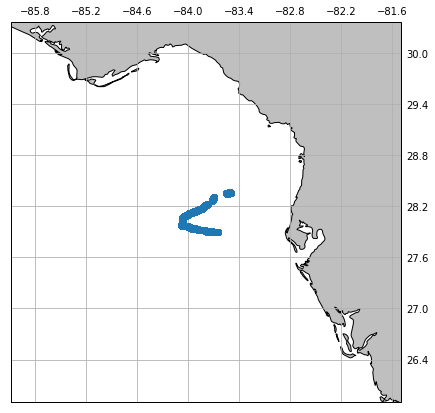

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


land_10m = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
     edgecolor='k', facecolor='0.75',
)


fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(7, 7)
)

ax.plot(df['longitude'], df['latitude'], 'o')

gl = ax.gridlines(draw_labels=True)
gl.xlabels_bottom = gl.ylabels_left = False

ax.add_feature(land_10m)

dx = dy = 2
ax.set_extent(
    [df['longitude'].min()-dx, df['longitude'].max()+dx,
     df['latitude'].min()-dy, df['latitude'].max()+dy]
);